In [62]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os

In [39]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [40]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Image into TF Data Pipeline

In [41]:
current_folder = os.path.abspath('')
IMAGES_PATH = os.path.join(current_folder,'data','images')
print(IMAGES_PATH)

images = tf.data.Dataset.list_files(IMAGES_PATH + '/*.jpg', shuffle=False)

/Users/kaijun/Document/UCLA/Clubs/SSA/Telebot/SSA_telebot/facial_recognition/image_collection/data/images


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: /Users/kaijun/Document/UCLA/Clubs/SSA/Telebot/SSA_telebot/facial_recognition/image_collection/data/images/*.jpg'

In [ ]:
images.as_numpy_iterator().next()

2023-07-30 17:48:16.887556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


b'/Users/kaijun/Document/UCLA/Clubs/SSA/Telebot/SSA_telebot/facial_recognition/image_collection/data/images/52f25046-2eb0-11ee-9794-166359f0a21b.jpg'

In [64]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

2023-07-30 17:48:28.797153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


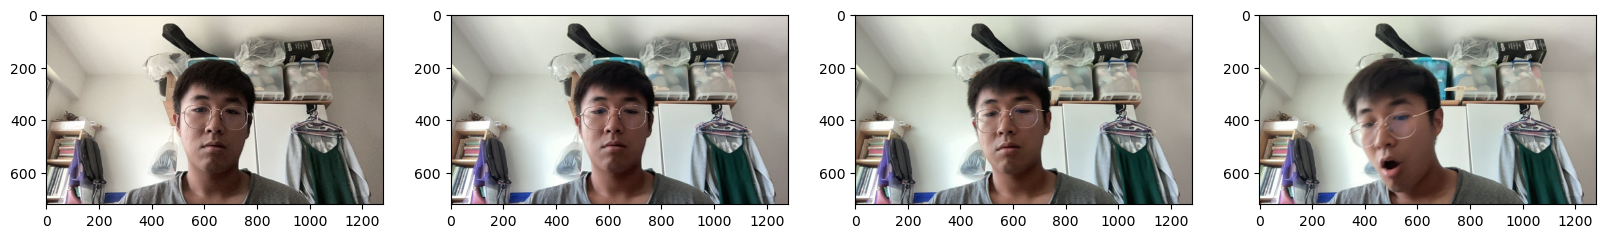

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Partition Unaugmented Data

In [ ]:
current_folder = os.path.abspath('')
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join(current_folder,'data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join(current_folder,'data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

## Apply Image Augmentation on Images and Labels using Albumentations
This part sets up the Albumentation pipeline and tests it on 1 image.

In [42]:
import albumentations as alb
import cv2

In [142]:
augmentor = alb.Compose([alb.RandomCrop(width=540, height=540), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [143]:
img = cv2.imread(os.path.join('data','train', 'images','8d8023dc-2eb0-11ee-b1eb-166359f0a21b.jpg'))
img.shape

(720, 1280, 3)

In [145]:
with open(os.path.join('data', 'train', 'labels', '8d8023dc-2eb0-11ee-b1eb-166359f0a21b.json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

[[511.2328767123288, 234.65753424657535],
 [687.945205479452, 477.12328767123284]]

In [147]:
# Shows the bounding box coordinates

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[511.2328767123288, 234.65753424657535, 687.945205479452, 477.12328767123284]

In [148]:
coords = list(np.divide(coords, [1280,720,1280,720]))
coords

[0.3994006849315069, 0.3259132420091324, 0.537457191780822, 0.6626712328767123]

In [149]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [150]:
augmented['bboxes']

[(0.0, 0.14381024860476913, 0.3184170471841707, 0.5928209030948757)]

In [151]:
augmented['bboxes'][0][2:]

(0.3184170471841707, 0.5928209030948757)

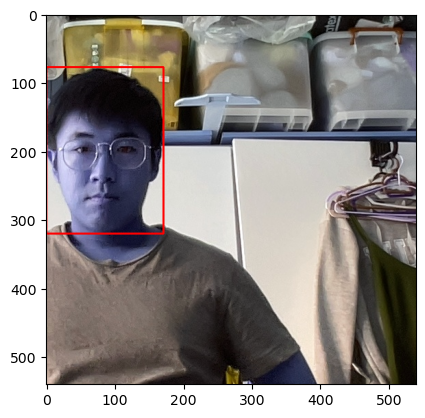

In [152]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [540,540]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [540,540]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

## Using the Albumentation Pipeline to Augment the Data

In [153]:
current_folder = os.path.abspath('')

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join(current_folder, 'data', partition, 'images')):
        img = cv2.imread(os.path.join(current_folder, 'data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(current_folder, 'data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(50):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join(current_folder, 'aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join(current_folder,  'aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.4111729452054795, 0.8339041095890412, 0.05158390410958903, 0.15468036529680368, 'face'].
x_max is less than or equal to x_min for bbox [0.5502996575342466, 0.24600456621004568, 0.23886986301369864, 0.7806316590563167, 'face'].
x_max is less than or equal to x_min for bbox [0.559931506849315, 0.4514840182648402, 0.26388652711285965, 0.9986111111111111, 'face'].
x_max is less than or equal to x_min for bbox [0.8542380136986301, 0.9271308980213091, 0.5074914383561644, 0.22127092846270932, 'face'].
y_max is less than or equal to y_min for bbox [0.4539811643835616, 0.6113013698630136, 0.734375, 0.05764840182648405, 'face'].
x_max is less than or equal to x_min for bbox [0.7354452054794521, 0.8091704718417049, 0.4839469178082192, 0.32971841704718424, 'face'].
x_max is less than or equal to x_min for bbox [0.3779965753424658, 0.8624429223744292, 0.02910958904109588, 0.14516742770167435, 'face'].
y_max is less than or equal to y_min for bbox [0.

Notes:
- `tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)` loads all the file names in the directory into a dataset.
- `train_images.map(load_image)` applies the `load_image` function to each element of the dataset.
- `train_images.map(lambda x: tf.image.resize(x, (120,120)))` applies a lambda function where  `tf.image.resize()` is called on each image and resizes them to 120x120.
- `train_images.map(lambda x: x/255)` applies a lambda function where each image is divided by 255 to decrease the data size (to improve processing speed).

In [155]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [156]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [157]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [158]:
train_images.as_numpy_iterator().next()

2023-07-31 01:30:52.802024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2500]
	 [[{{node Placeholder/_0}}]]


array([[[0.66568625, 0.64215684, 0.59313726],
        [0.6517157 , 0.6281863 , 0.58112746],
        [0.6125    , 0.5889706 , 0.5419118 ],
        ...,
        [0.8747549 , 0.84338236, 0.7943627 ],
        [0.87671566, 0.8453431 , 0.7943627 ],
        [0.86789215, 0.8365196 , 0.7855392 ]],

       [[0.6377451 , 0.60637254, 0.5632353 ],
        [0.63480395, 0.60343134, 0.5602941 ],
        [0.6193628 , 0.5879902 , 0.5448529 ],
        ...,
        [0.86764705, 0.8362745 , 0.7852941 ],
        [0.85294116, 0.8215686 , 0.77843136],
        [0.8426471 , 0.8112745 , 0.7681373 ]],

       [[0.6125    , 0.58504903, 0.54583335],
        [0.6485294 , 0.62107843, 0.58186275],
        [0.6254902 , 0.5980392 , 0.5588235 ],
        ...,
        [0.88210785, 0.8507353 , 0.7997549 ],
        [0.86813724, 0.8367647 , 0.79362744],
        [0.8509804 , 0.81960785, 0.7764706 ]],

       ...,

       [[0.17254902, 0.06666667, 0.03995098],
        [0.19828431, 0.09240196, 0.06495098],
        [0.19289216, 0

## Prepare Labels

In [83]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [159]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [160]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [161]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [162]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2500, 2500, 650, 650, 600, 600)

Notes:
- `zip()` function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc.
- `shuffle()` function takes a sequence (list, string, or tuple) and reorganize the order of the items.
- `batch()` function combines consecutive elements of a dataset into batches.
- `prefetch()` function allows later elements to be prepared while the current element is being processed. It can be used to overlap the preprocessing and model execution of a training dataset.

In [163]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [164]:
train.as_numpy_iterator().next()[1]

2023-07-31 01:31:22.201711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [2500]
	 [[{{node Placeholder/_5}}]]
2023-07-31 01:31:22.202288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [2500]
	 [[{{node Placeholder/_5}}]]


(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3186 , 0.0782 , 0.9756 , 0.872  ],
        [0.2079 , 0.222  , 0.7837 , 0.8843 ],
        [0.     , 0.736  , 0.3147 , 1.     ],
        [0.02052, 0.2139 , 0.5684 , 0.795  ],
        [0.4207 , 0.3115 , 1.     , 1.     ],
        [0.     , 0.5166 , 0.06223, 0.9404 ],
        [0.     , 0.     , 0.34   , 1.     ],
        [0.     , 0.00949, 0.4026 , 0.7627 ]], dtype=float16))

In [165]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [166]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4) 

In [177]:
data_samples = train.as_numpy_iterator()

In [231]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


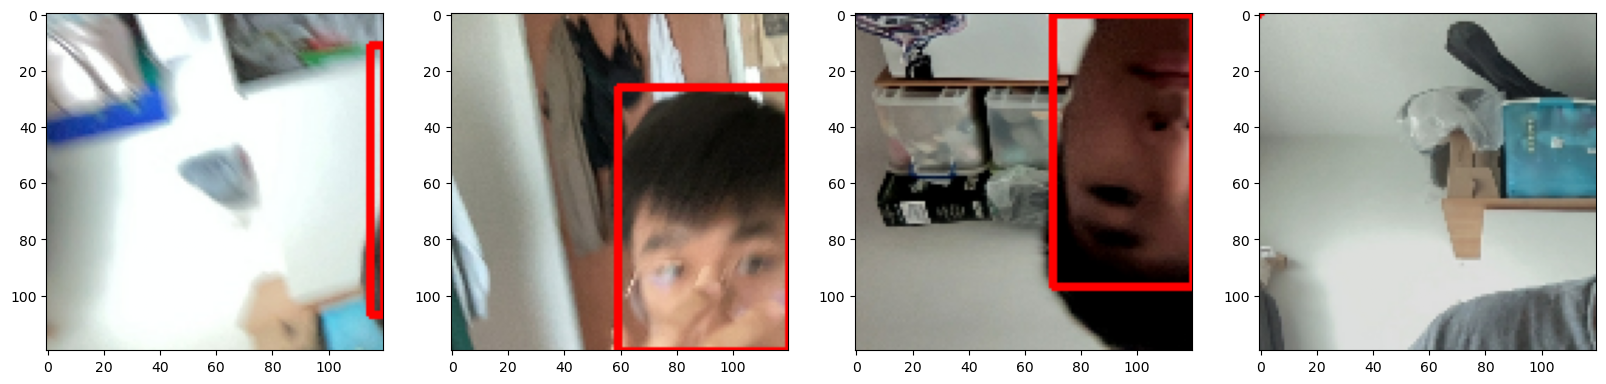

In [232]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Build Deep Learning using the Functional API

Notes:
- Our problem is both a classification problem as we are trying to determine whether the object is a 'face', and it is also a regression problem because we are trying to predict the coordinates of the bounding box.
- Keras is a higher level API that runs on top of TensorFlow. It is easier to use and has a simpler syntax while still allowing for full customization.
- VGG16 is a convolutional neural network model that is pre-trained. We will cut off the last few layers of the model as it is meant to do classification but we need BOTH classification and regression (for localization).

In [181]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [182]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

In [183]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [184]:
facetracker = build_model()

In [185]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_7[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

#### Example

In [186]:
X, y = train.as_numpy_iterator().next()

In [187]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 246ms/step


2023-07-31 01:33:22.228991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [188]:
classes, coords

(array([[0.7763647 ],
        [0.7225977 ],
        [0.55693537],
        [0.5092943 ],
        [0.5551516 ],
        [0.70711946],
        [0.5364375 ],
        [0.77281475]], dtype=float32),
 array([[0.6692691 , 0.92769367, 0.41398543, 0.5320523 ],
        [0.7542753 , 0.974279  , 0.5813467 , 0.6367218 ],
        [0.6985251 , 0.8968814 , 0.5901965 , 0.7274947 ],
        [0.54627985, 0.81033087, 0.60564375, 0.7118439 ],
        [0.5057587 , 0.8891767 , 0.42440468, 0.65333414],
        [0.7923328 , 0.91408813, 0.5217276 , 0.5509933 ],
        [0.65719295, 0.86928755, 0.5332251 , 0.7183278 ],
        [0.7180403 , 0.8910294 , 0.5171734 , 0.6965707 ]], dtype=float32))

## Define Losses and Optimizers

We're using Adam as our optimizer
- Optimizer figure out how to apply the best gradients and effectively apply back-propagation across the neural network

In [201]:
#### this method is deprecated
# batches_per_epoch = len(train)
# lr_decay = (1./0.75 -1)/batches_per_epoch
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)


# this is to set up the learning rate to be 75% of the previous epoch's learning rate so 
# that we slow down the learning rate as we continue to train the model so that we don't 
# overfit and blow out the gradients

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1,
    decay_rate=0.75)

In [202]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#### Create Localization Loss and Classification Loss

Notes:
- calculating binary cross entropy loss (aka logarithmic loss) for CLASSIFICATION LOSS
- calculating localization loss for REGRESSION LOSS
  1. we're getting the distance between our actual coordinate vs the predicted coordinate
  2. we're getting the square of the height diff and the square of the width diff
      - then we're getting the actual height & width of the bounding box
      - then we're getting the predicted height & width of the bounding box

In [191]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [192]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

##### Example

In [127]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.1576853>

In [128]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7247399>

In [129]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.1576853>

## Train Neural Network

In [203]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.opt = opt
        self.closs = classloss
        self.lloss = localizationloss
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            # this 0.5 is a hyperparameter that we can tune to see how much we want to penalize the classification loss
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            # calculates the gradients with respect to the loss function
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        # applying one step of gradient descent for the backpropagation
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        # notice no backpropagation here !!
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [204]:
model = FaceTracker(facetracker)

In [205]:
model.compile(opt, classloss, regressloss)

#### Training

In [196]:
logdir='logs'

In [206]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [207]:
hist = model.fit(train.take(150), epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15


2023-07-31 01:37:54.566960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2500]
	 [[{{node Placeholder/_0}}]]
2023-07-31 01:37:54.567267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [2500]
	 [[{{node Placeholder/_5}}]]
2023-07-31 01:37:57.172697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-31 01:37:57.491621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain termin

150/150 [==============================] - ETA: 0s - total_loss: 11.4842 - class_loss: 4.4477 - regress_loss: 9.2604

2023-07-31 01:38:27.146588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 37s 187ms/step - total_loss: 11.4549 - class_loss: 4.4309 - regress_loss: 9.2395 - val_total_loss: 12.6397 - val_class_loss: 5.7185 - val_regress_loss: 9.7805
Epoch 2/15
150/150 [==============================] - 32s 184ms/step - total_loss: 11.4056 - class_loss: 4.1784 - regress_loss: 9.3164 - val_total_loss: 4.5502 - val_class_loss: 0.0000e+00 - val_regress_loss: 4.5502
Epoch 3/15
150/150 [==============================] - 31s 183ms/step - total_loss: 11.2800 - class_loss: 4.1405 - regress_loss: 9.2098 - val_total_loss: 9.5618 - val_class_loss: 1.9062 - val_regress_loss: 8.6088
Epoch 4/15
150/150 [==============================] - 31s 185ms/step - total_loss: 11.4922 - class_loss: 4.3551 - regress_loss: 9.3146 - val_total_loss: 12.4443 - val_class_loss: 5.7185 - val_regress_loss: 9.5851
Epoch 5/15
150/150 [==============================] - 31s 181ms/step - total_loss: 11.4033 - class_loss: 4.2289 - regress_loss: 9.2889 - val_total_loss: 13.1

## Plotting Performance

In [208]:
hist.history

{'total_loss': [7.0573835372924805,
  13.06592845916748,
  14.132505416870117,
  13.495539665222168,
  17.933090209960938,
  10.209094047546387,
  13.616601943969727,
  12.590117454528809,
  15.618953704833984,
  11.009109497070312,
  14.681824684143066,
  9.85895824432373,
  12.280206680297852,
  8.081592559814453,
  10.048747062683105],
 'class_loss': [1.906154751777649,
  5.718464374542236,
  5.718464374542236,
  5.718464374542236,
  5.718464374542236,
  3.812309503555298,
  7.624619007110596,
  3.812309503555298,
  9.530774116516113,
  3.812309503555298,
  5.718464374542236,
  3.812309503555298,
  5.718464374542236,
  1.906154751777649,
  5.718464374542236],
 'regress_loss': [6.104306221008301,
  10.206696510314941,
  11.273273468017578,
  10.636307716369629,
  15.073857307434082,
  8.302939414978027,
  9.804292678833008,
  10.68396282196045,
  10.85356616973877,
  9.102954864501953,
  11.822592735290527,
  7.952803134918213,
  9.420974731445312,
  7.128515243530273,
  7.1895151138

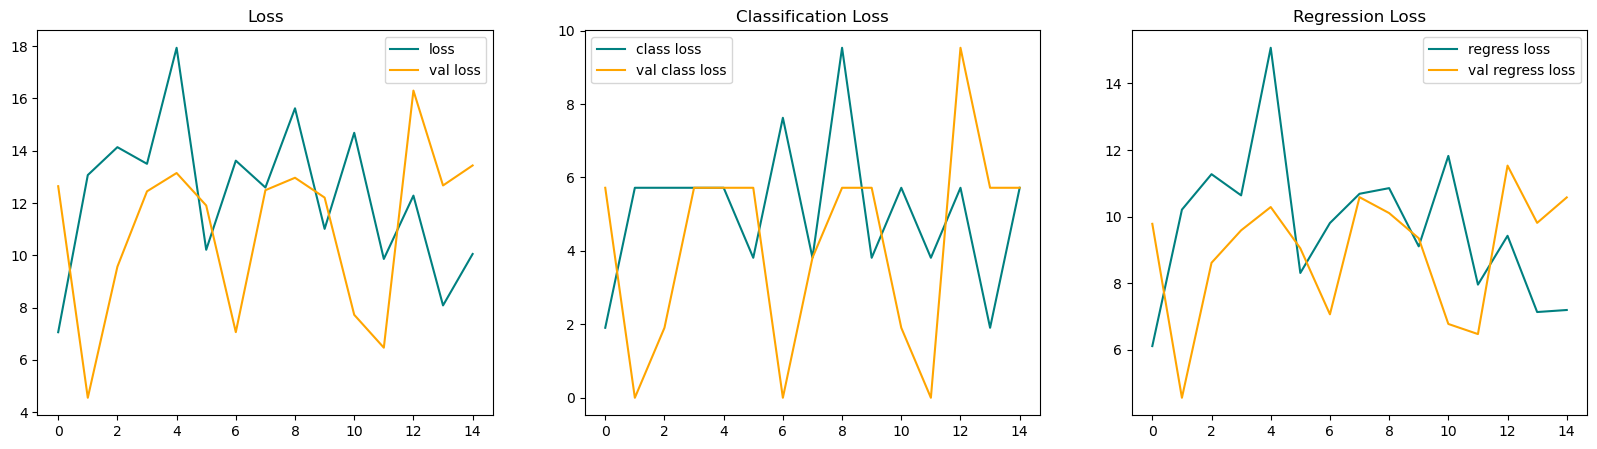

In [209]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Making Predictions / Testing

In [210]:
test_data = test.as_numpy_iterator()

2023-07-31 01:46:13.329414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [650]
	 [[{{node Placeholder/_0}}]]
2023-07-31 01:46:13.329991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [650]
	 [[{{node Placeholder/_0}}]]


In [243]:
test_sample = test_data.next()

In [236]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


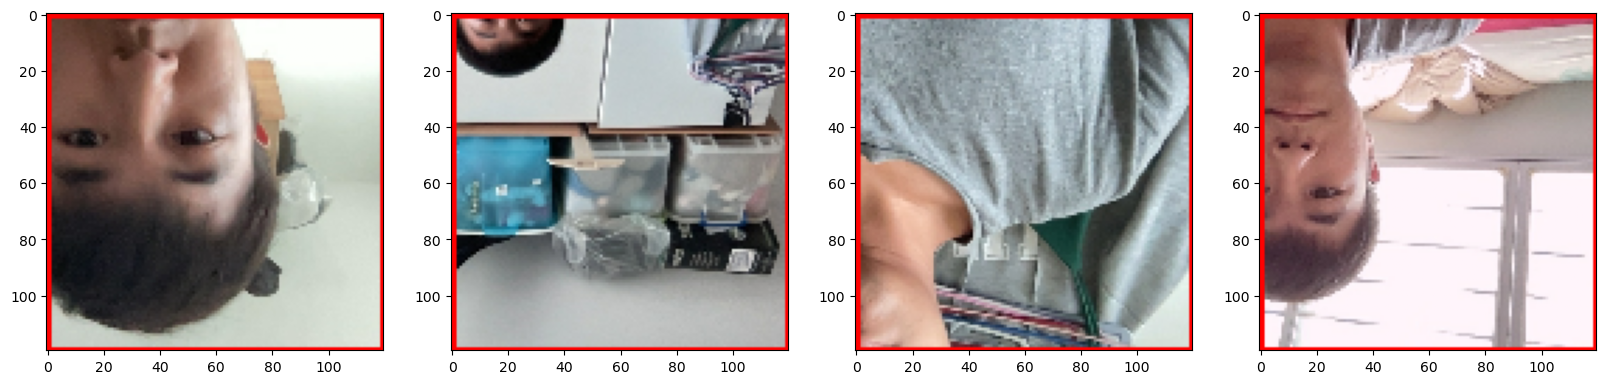

In [244]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Saving the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

## Real-Time Test

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()